<a href="https://colab.research.google.com/github/pranavraghav75/noise2image_ISL/blob/main/noise2image_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/rmcao/noise2image.git
%cd noise2image
!pip install -r requirements.txt

Cloning into 'noise2image'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 39 (delta 11), reused 36 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 73.61 KiB | 575.00 KiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/noise2image/noise2image
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 95.1 MB/s eta 0:00:

In [ ]:
%cd noise2image/

/content/noise2image


In [ ]:
!pip install denoising_diffusion_pytorch
!pip install snntorch
import sys, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate
from utils import EventImagePairDataset, data_split
from models.unet_attention import Unet

In [ ]:
INDIST_EVENT_PATH = "/content/drive/MyDrive/Noise2ImageData/indist_events"
INDIST_IMAGE_PATH = "/content/drive/MyDrive/Noise2ImageData/indist_images"

full_ds = EventImagePairDataset(
    image_folder       = INDIST_IMAGE_PATH,
    event_folder       = INDIST_EVENT_PATH,
    integration_time_s = 1.0,
    total_time_s       = 10.0,
    start_time_s       = 0.0,
    time_bin           = 1,   # adjust for more timesteps if desired
    pixel_bin          = 4,
    polarity           = True,
    std_channel        = False,
    transform          = None,
)
train_ds, val_ds, test_ds = data_split(full_ds,
    validation_split=0.1, testing_split=0.1, seed=42)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,
                           num_workers=2, pin_memory=True)

test_loader = DataLoader(
    test_ds,
    batch_size   = 2,
    shuffle      = False,
    num_workers  = 2,
    pin_memory   = True,
)

x, y, t = next(iter(train_loader))
print("x:", x.shape, " y:", y.shape, " t:", t.shape)

  8%|▊         | 86/1013 [00:22<00:41, 22.38it/s]

Image 397mimKyA1U.jpg has invalid shape (1078, 1920)


 11%|█         | 107/1013 [00:22<00:27, 32.83it/s]

Image 4bmtMXGuVqo.jpg has invalid shape (1021, 1920)


 13%|█▎        | 127/1013 [00:23<00:24, 36.18it/s]

Image 5OpRAWgqiP0.jpg has invalid shape (960, 1920)


 24%|██▍       | 246/1013 [00:24<00:13, 57.67it/s]

Image DCMv2-WH3j0.jpg has invalid shape (1053, 1920)


 38%|███▊      | 384/1013 [00:27<00:06, 95.66it/s]

Image NW2AVFgqkAg.jpg has invalid shape (1079, 1920)


 52%|█████▏    | 528/1013 [00:29<00:08, 55.19it/s]

Image X3Hr-imgBjE.jpg has invalid shape (864, 1920)


 70%|███████   | 713/1013 [00:35<00:08, 33.95it/s]

Image hRvTsx8A7Eo.jpg has invalid shape (1078, 1920)


 72%|███████▏  | 725/1013 [00:35<00:05, 51.72it/s]

Image i_ZoH4LHPwY.jpg has invalid shape (1078, 1920)


 78%|███████▊  | 789/1013 [00:36<00:02, 87.45it/s]

Image mbg7T5w2Kpg.jpg has invalid shape (1077, 1920)


100%|██████████| 1013/1013 [00:43<00:00, 23.45it/s]


x: torch.Size([2, 2, 180, 320])  y: torch.Size([2, 1, 180, 320])  t: torch.Size([2])


In [ ]:
# # 2) test spiking Unet
# beta       = 0.9
# spike_grad = surrogate.fast_sigmoid(slope=25)

# class SpikingUNetTiny(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.enc_conv = nn.Conv2d(1, 16, 3, padding=1)
#         self.enc_lif  = snn.Leaky(beta=beta,
#                                  spike_grad=spike_grad,
#                                  init_hidden=False)
#         self.dec_conv = nn.Conv2d(16, 1, 3, padding=1)

#     def forward(self, x):
#         T, B, C, H, W = x.shape
#         mem = self.enc_lif.init_leaky()
#         out_seq = []

#         for t in range(T):
#             cur = self.enc_conv(x[t])
#             spk, mem = self.enc_lif(cur, mem)
#             y = self.dec_conv(spk)
#             out_seq.append(y)

#         return torch.stack(out_seq)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net    = SpikingUNetTiny().to(device)
# opt    = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
# 2) spiking Unet using unet from noise2image
beta       = 0.95
spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingUnet(nn.Module):
    def __init__(self,
                 dim=64,
                 in_channels=1,
                 out_channels=1,
                 dim_mults=(1,2,4,8)):
        super().__init__()

        self.unet = Unet(
            dim         = dim,
            in_channels = in_channels,
            out_channels= out_channels,
            dim_mults   = dim_mults,
        )

        self._swap_activations(self.unet)

    def _swap_activations(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.SiLU):
                setattr(module, name,
                        snn.Leaky(beta=beta,
                                  spike_grad=spike_grad,
                                  init_hidden=True))
            else:
                self._swap_activations(child)

    def forward(self, x):
        """
        x: [T, B, C, H, W]
        returns: [T, B, 1, H, W]
        """
        T, B, C, H, W = x.shape

        for m in self.unet.modules():
            if isinstance(m, snn.Leaky):
                m.init_leaky()

        out_seq = []
        for t in range(T):
            frame = x[t]
            pad_h = (8 - (H % 8)) % 8
            pad_w = (8 - (W % 8)) % 8
            pad = (pad_w//2, pad_w - pad_w//2,
                   pad_h//2, pad_h - pad_h//2)

            fp = F.pad(frame, pad)
            time_tensor = torch.tensor([t], device=fp.device)
            y_hat_padded = self.unet(fp, time_tensor)
            y_hat = y_hat_padded[
                  :,
                  :,
                  pad[2]:pad[2] + H,
                  pad[0]:pad[0] + W
            ]
            out_seq.append(y_hat)

        return torch.stack(out_seq, dim=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net    = SpikingUnet(dim=32, in_channels=1, out_channels=1).to(device)
opt    = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
# 3) training loop
num_epochs = 5

for epoch in range(1, num_epochs+1):
    net.train()
    running_loss = 0.0
    for noise, clean, _ in train_loader:
        noise = noise.to(device)
        clean = clean.to(device).squeeze(1)

        x = noise.unsqueeze(1).permute(2,0,1,3,4)

        out_seq = net(x)
        recon   = out_seq.mean(0).squeeze(1)
        loss    = F.mse_loss(recon, clean)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs} — Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5 — Avg Loss: 0.0709
Epoch 2/5 — Avg Loss: 0.0150
Epoch 3/5 — Avg Loss: 0.0113
Epoch 4/5 — Avg Loss: 0.0103
Epoch 5/5 — Avg Loss: 0.0094


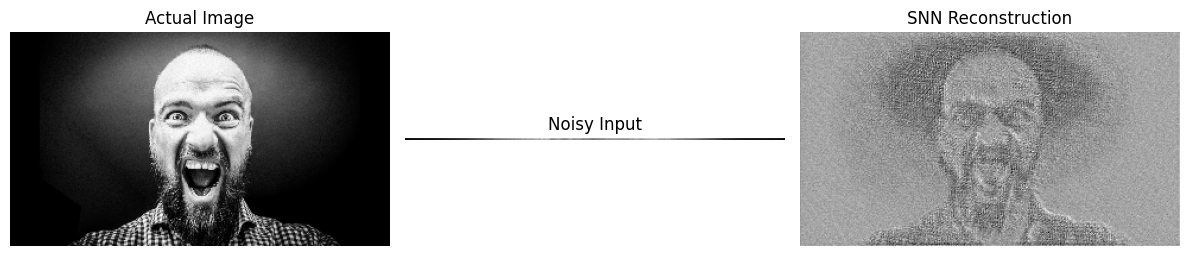

In [20]:
import torch
import matplotlib.pyplot as plt

net.eval()

noise, clean, _ = next(iter(test_loader))

noise = noise.to(device)
clean = clean.to(device).squeeze(1)
x     = noise.unsqueeze(1).permute(2, 0, 1, 3, 4)

with torch.no_grad():
    out_seq = net(x)
    recon   = out_seq.mean(0).squeeze(1)

# Random Index for Image
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Actual Image
axes[0].imshow(clean[0].cpu(), cmap="gray")
axes[0].set_title("Actual Image")

noisy_frame = noise[0].sum(dim=1).cpu()
axes[1].imshow(noisy_frame, cmap="gray")
axes[1].set_title("Noisy Input")

# SNN Reconstruction
axes[2].imshow(recon[0].cpu(), cmap="gray")
axes[2].set_title("SNN Reconstruction")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()